In [2]:
import MS_helper_functions as ms
from meshGen import mesh2DLaminates
import matplotlib.pyplot as plt
%matplotlib widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import importlib 
importlib.reload(ms)
numSheets = 3
D = 0.04
d = 0.02
ff = 0.7
numSheets = 4
maxh_edges = d/numSheets*1/2 * 0.1
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=True, quad_dominated=False)
meshRef = cMeshRef.mesh

modelHalfAir=False
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", maxh_edges=maxh_edges, rotated=True, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh


importlib.reload(ms)
ms.cl_Phi.numSheets = numSheets
ms.cl_Phi.dFe = cMeshMS.dFe
ms.cl_Phi.d0 = cMeshMS.d0
ms.cl_Phi.mesh = meshMS

ms.cl_Phi.modelHalfAir = modelHalfAir
ms.cl_Phi.orientation = 1




maxh_edges [0.00025, 0.00025]
maxh_edges [0.00025, 0.00025]


In [3]:
from ngsolve.webgui import Draw
from ngsolve import CF, Mesh, GridFunction, H1, x, y, exp
from netgen.occ import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))

sol = GridFunction(H1(mesh))

x_init = 0.5
sol.Set(x_init)

settings = {"Objects":{"Wireframe":False}, "deformation":0.5, "camera": {"transformations":[{"type":"rotateX", "angle":-22.5}]}}

scene1 = Draw(sol, mesh, settings = settings, deformation=True)

def slider_func1(val):

    
    sol.Set(exp(-((x-0.5)**2 + (y-0.5)**2 )/(0.2*val)))
    scene1.Redraw()

interact(slider_func1, val=widgets.FloatSlider(min=0, max=1, step=0.05, value=x_init))

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

interactive(children=(FloatSlider(value=0.5, description='val', max=1.0, step=0.05), Output()), _dom_classes=(…

<function __main__.slider_func1(val)>

In [4]:

from ngsolve import *
from netgen.occ import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ngsolve.webgui import Draw

mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))

# H1-conforming finite element space
fes = H1(mesh, order=3, dirichlet=[1,2,3,4])
coef = Parameter(32)

# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

# the right hand side
f = LinearForm(fes)
f += coef * (y*(1-y)+x*(1-x)) * v * dx

# the bilinear-form 
a = BilinearForm(fes, symmetric=True)
a += grad(u)*grad(v)*dx

a.Assemble()

gfu = GridFunction(fes)

def solve():
    f.Assemble()

    gfu.vec.data = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec

    print(gfu.vec.Norm())

settings = {"Objects":{"Wireframe":False}, "deformation":0.5, "camera": {"transformations":[{"type":"rotateX", "angle":-22.5}]}}
scene1 = Draw(gfu, mesh, settings = settings, deformation=True)

def slider_func1(val):

    print(val)
    coef.Set(val)
    solve()

    scene1.Redraw()

interact(slider_func1, val=widgets.FloatSlider(min=0, max=100, step=10, value=32))


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

interactive(children=(FloatSlider(value=32.0, description='val', step=10.0), Output()), _dom_classes=('widget-…

<function __main__.slider_func1(val)>

In [5]:

from netgen.geom2d import unit_square
# import netgen.gui
from ngsolve import Draw, CF, Mesh, x
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
Draw(CF(2000*x), mesh, "name", unit=" unit", title="title", number_format="%.3f", autoscale=False, min = 0, max=2000)


In [7]:
importlib.reload(ms)


cl_Phi = ms.cl_Phi

cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1

phi = ms.pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), [lambda x : 1, lambda x:0], cl_Phi.numSheets, cl_Phi.getFF(), cl_Phi.orientation )
dzphi = phi.getDiff()

orderPhi = [
        # ms.cl_Phi(1, 
                    # modelHalfAir=False, inAir=True, specialFirstLast=True, 
                    # specialFirstLast_func=[lambda x : 1/ms.cl_Phi.dFe*(x+ms.cl_Phi.dFe/2), lambda x:1/ms.cl_Phi.dFe*(x-ms.cl_Phi.dFe/2)], 
                    # specialFirstLast_dzfunc=[lambda x : 1/ms.cl_Phi.dFe, lambda x : 1/ms.cl_Phi.dFe]), 
        ms.cl_Phi(1)
    ]
print(ms.getPhiPhiValue(orderPhi[0].dzphi, ms.cl_Phi(0).phi, 1000, 1, ms.cl_Phi.dFe, ms.cl_Phi.d0, force_full_Phi=True, force_num_int=True))
# ms.cl_Phi.plotEvaluated(orderPhi)
# ms.cl_Phi.plotDirectEvaluated(orderPhi)



399700.0


In [8]:
xi = np.linspace(-d/2, d/2, 200)
plt.figure()
for phi in orderPhi:
    yi = [phi.phi.DirectEvaluate(x) + i * 0.5 for x in xi]

    plt.plot(xi, np.array(yi) )
    print("here")


NameError: name 'np' is not defined

In [9]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine


from meshGen import mesh2DLaminates

D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1



rotated = True

cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=rotated, modelHalfAir=False, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshRef.dFe
cl_Phi.d0 = cMeshRef.d0
cl_Phi.mesh = meshRef

cl_Phi.modelHalfAir = true
cl_Phi.orientation = 1 if rotated else 0

maxh_edges [0.00025, 0.00025]
Boundaries {'bottom', 'iright', 'ileft', 'ibottom', 'itop', 'right', 'left', 'top'}
Materials {'insulation', 'inner', 'outer'}


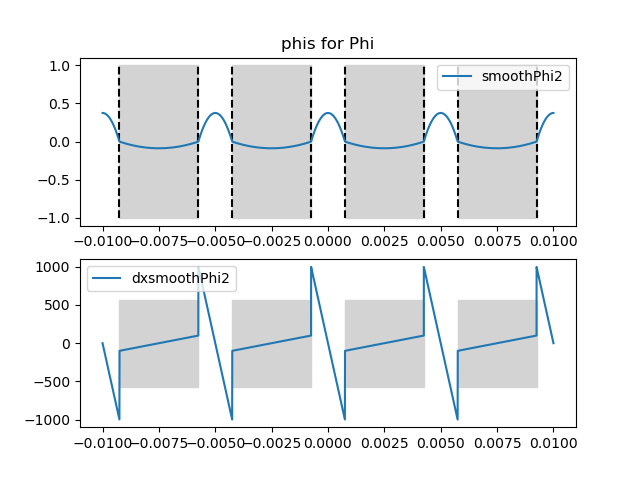

In [21]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshRef.dFe
cl_Phi.d0 = cMeshRef.d0
cl_Phi.mesh = meshRef

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 1 if rotated else 0

lambda2 = 10
lambda1 = 1


fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/dFe * 1 - (dFe/4 * 1))
fun_0 = lambda x: 1e3*(-(x - (d0/2+dFe/2))**2/ d0 * 1 + d0/4 * 1)

smoothPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), [fun_Fe, fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothPhi2")
oo = cl_Phi([smoothPhi2, smoothPhi2.getDiff()])


cl_Phi.plotEvaluated([oo])

interactive(children=(FloatSlider(value=32.0, description='val', min=10.0, step=1.0), Output()), _dom_classes=…

Checkbox(value=True, description='checker0')

Checkbox(value=True, description='checker1')

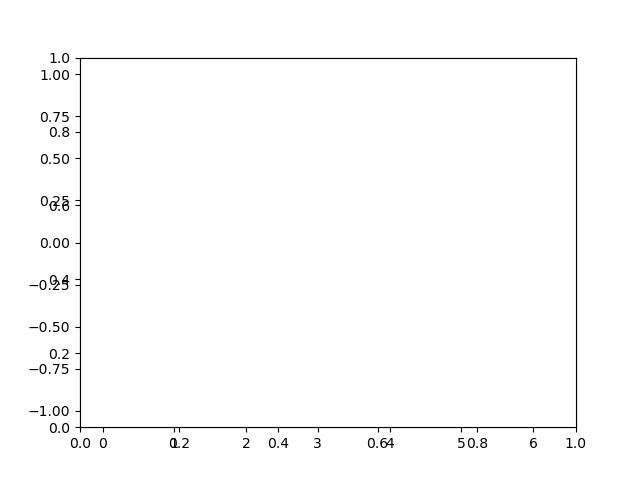

In [29]:

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()
import numpy as np

def drawComponents(vals):
    # [ plt.plot(xi, vals[i]) if checkBox_i[i].value else None for i in range(len(vals)) ]

    # plt.figure(1)
    
    # [ print(checkBox_i[i].value) for i in range(len(vals)) ]
    # [ plt.plot(xi, vals[i])  for i in range(len(vals))  if checkBox_i[i].value ]
    ax.clear()
    for i in range(len(vals)):
        if checkBox_i[i].value:
            plt.plot(vals[i][0], vals[i][1], **vals[i][2])
    plt.draw()



vals = []

def calcVals(N = 10):
    xi = np.linspace(0, 2*np.pi, int(N))
    vals.clear()
    vals.append([xi, np.sin(xi), {"ls":"--", "c":"b", "marker":"x"}])
    vals.append([xi, np.cos(xi), {"c":"r"}])



def slider_func1(val):

    calcVals(val)
    drawComponents(vals)

def checkBox_func(val):
    # print("---------")
    if val["name"] == "value":
        status = val["new"]
        # print(val["owner"].description)
        # print(status)
        drawComponents(vals)

interact(slider_func1, val=widgets.FloatSlider(min=10, max=100, step=1, value=32))

checkBox_i = []

for i in range(len(vals)):
    checkBox=widgets.Checkbox(True, description='checker' + str(i))
    checkBox.observe(checkBox_func)
    checkBox_i.append(checkBox)
    display(checkBox)

fig = plt.figure(1)
ax = fig.add_subplot(111)
fig.show()
drawComponents(vals)


